### Extraction database

In [2]:
import os
import zipfile
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import shutil

# Nom du fichier ZIP dans le même dossier que le notebook
ZIP_NAME = "GESRes_dataset.zip"

# Dossier où extraire la base
OUTPUT_DIR = "GESRes_dataset"

os.makedirs(OUTPUT_DIR, exist_ok=True)

print("📦 Extraction en cours :", ZIP_NAME)

with zipfile.ZipFile(ZIP_NAME, 'r') as zip_ref:
    zip_ref.extractall(OUTPUT_DIR)

print("🎉 Extraction terminée dans :", OUTPUT_DIR)


📦 Extraction en cours : GESRes_dataset.zip
🎉 Extraction terminée dans : GESRes_dataset


In [3]:
for root, dirs, files in os.walk("GESRes_dataset"):
    print(root, "→", len(files), "fichiers")


GESRes_dataset → 10 fichiers
GESRes_dataset/01Gesture_videos → 987 fichiers
GESRes_dataset/02Full_videos → 7 fichiers
GESRes_dataset/03Transcripts → 11 fichiers
GESRes_dataset/05Code → 14 fichiers
GESRes_dataset/05Code/02DataSetEvaluation → 6 fichiers
GESRes_dataset/05Code/02DataSetEvaluation/CrossCheckAnnotations → 9 fichiers
GESRes_dataset/05Code/01Annotations → 13 fichiers
GESRes_dataset/04Tracking_data → 2 fichiers


### Lecture d'une vidéo

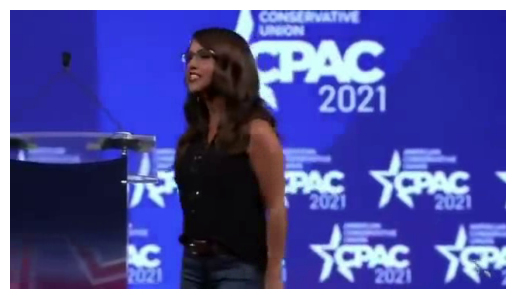

In [4]:
video_path = "GESRes_dataset/01Gesture_videos/897_Politician3_hand_flip.mp4"

cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Impossible d'ouvrir la vidéo.")
else:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        clear_output(wait=True)
        plt.imshow(frame_rgb)
        plt.axis("off")
        plt.show()

        time.sleep(0.02)  # environ 25 fps

    cap.release()


### Recherche des différentes catégories de geste

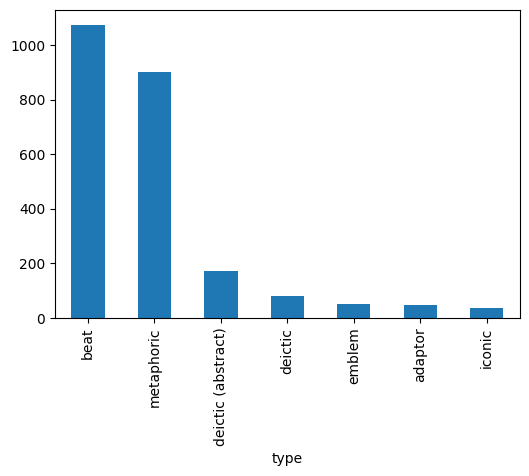

In [5]:
csv_path = "GESRes_dataset/GESRes_dataset.csv"
df = pd.read_csv(csv_path)
df['type'].value_counts().plot(kind='bar', figsize=(6,4))

df["idx"] = df["Unnamed: 0"].astype(int)


### Définition des différents gestes sociaux

Définir les keywords + filtrage positif/négatif

In [6]:
positive_keywords = [
    "point", "index", "finger", "deictic",
    "wave", "waving", "hello", "salut", "greet",
    "show", "present", "open hand", "palm", "hand flip",
    "stop", "come", "wait", "ok", "thumb",
    "hand", "hold", "flip",
]

negative_keywords = ["count", "rub", "touch", "ring", "ladder"]

# Filtrage positif
pos = df[df["lexeme"].astype(str).str.contains("|".join(positive_keywords), case=False, na=False)]

# Filtrage négatif
mask_negative = pos["lexeme"].astype(str).str.contains("|".join(negative_keywords), case=False, na=False)

df_clean = pos[~mask_negative].copy()

print("Nombre de gestes filtrés :", len(df_clean))
df_clean[["idx", "lexeme", "id_short"]].head()





Nombre de gestes filtrés : 686


,idx,lexeme,id_short
2,3,hold,Politician1
20,21,wave,Politician1
22,23,point (forward),Politician1
28,29,hold close,Politician1
33,34,show,Politician1


### Supprimer les indexes sans vidéos

In [7]:
invalid_ranges = [
    (20, 823),
    (947, 1117),
    (1196, 1606)
]

def is_invalid(idx):
    return any(start <= idx <= end for start, end in invalid_ranges)

df_clean = df_clean[~df_clean["idx"].apply(is_invalid)].copy()

print("Après retrait des indexes sans vidéos :", len(df_clean))

            

Après retrait des indexes sans vidéos : 321


### Construire le mapping idx → noms de vidéos réels

In [8]:
video_dir = "GESRes_dataset/01Gesture_videos"
video_files = os.listdir(video_dir)

# mapping index → liste de fichiers correspondants
index_to_files = {}

for f in video_files:
    if "_" in f:
        prefix = f.split("_")[0]
        if prefix.isdigit():
            index_to_files.setdefault(int(prefix), []).append(f)

len(index_to_files)

987

In [9]:
df_clean["video_files"] = df_clean["idx"].apply(
    lambda x: index_to_files.get(x, [])
)

# Garder seulement les lignes avec au moins une vidéo
df_valid = df_clean[df_clean["video_files"].apply(len) > 0].copy()

print("Nombre de gestes associés à des vidéos :", len(df_valid))
df_valid[["idx", "lexeme", "video_files"]].head()


Nombre de gestes associés à des vidéos : 321


,idx,lexeme,video_files
2,3,hold,[3_Politician1_hold.mp4]
823,824,show,[824_Politician3_show.mp4]
829,830,show,[830_Politician3_show.mp4]
833,834,point (to side),[834_Politician3_point_to_side.mp4]
837,838,point (up),[838_Politician3_point_up.mp4]


In [10]:
DEST = "GESRes_filtered_gestures"
os.makedirs(DEST, exist_ok=True)

def normalize(s):
    return (
        str(s).lower()
        .replace(" ", "_")
        .replace("-", "_")
        .replace("(", "")
        .replace(")", "")
    )

df_valid["lexeme_norm"] = df_valid["lexeme"].apply(normalize)
df_valid["gesture_cat"] = df_valid["lexeme_norm"].apply(lambda s: s.split("_")[0])  # ex: point, wave…


### Copier les vidéos dans des dossiers séparés par catégorie de geste

In [11]:
copied = 0

for _, row in df_valid.iterrows():
    gesture = row["gesture_cat"]
    gesture_dir = os.path.join(DEST, gesture)
    os.makedirs(gesture_dir, exist_ok=True)

    for fname in row["video_files"]:
        src = os.path.join(video_dir, fname)
        dst = os.path.join(gesture_dir, fname)

        if not os.path.exists(dst):
            shutil.copy(src, dst)
            copied += 1

print("📦 Vidéos copiées :", copied)
print("📂 Dataset final :", DEST)


📦 Vidéos copiées : 0
📂 Dataset final : GESRes_filtered_gestures


### Code permettant de visionner des exemples dans chaque catégorie de geste

Pour visionner une autre vidéo, il suffit de changer la variable __video_path__

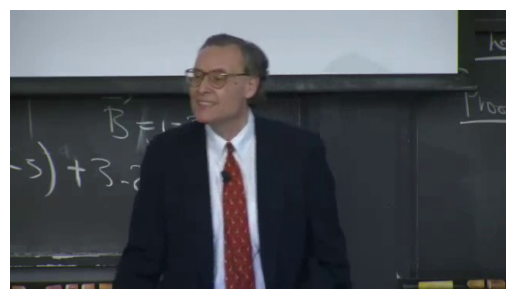

In [12]:
video_path = "GESRes_filtered_gestures/point/1673_Lecturer1_point_forward.mp4"

cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Impossible d'ouvrir la vidéo.")
else:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        clear_output(wait=True)
        plt.imshow(frame_rgb)
        plt.axis("off")
        plt.show()

        time.sleep(0.02)  # environ 25 fps

    cap.release()
